In [1]:
# Import required libraries
import os
import sys
import h5py
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split

# Add DECT library to path (adjust this path to your DECT installation)
sys.path.append(os.path.abspath('../dect'))

# Import DECT components
from dect.directions import generate_uniform_directions
from dect.nn import ECTLayer, ECTConfig
from dect.ect import compute_ect_points

# Check if CUDA is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
print(f"Using device: {device}")

/home/zh/miniconda3/envs/ect/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [5]:
# Load and explore the HDF5 file structure
data_dir = './data'  # Update this to your data directory
hdf5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) 
              if f.endswith('.hdf5') or f.endswith('.h5')]

if hdf5_files:
    print(f"Found {len(hdf5_files)} HDF5 files:")
    for i, file in enumerate(hdf5_files):
        print(f"{i+1}. {os.path.basename(file)}")
    
    # Get the first file for exploration
    first_file = hdf5_files[0]
    print(f"\nSelected file: {os.path.basename(first_file)}")
    
    # Show top-level groups in the file
    with h5py.File(first_file, 'r') as f:
        top_groups = list(f.keys())
        print(f"Available human models: {len(top_groups)}")
        print(f"First few models: {top_groups[:5]}")
else:
    print("No HDF5 files found. Please update the data_dir path.")

Found 2 HDF5 files:
1. cihp_sampled_pcs_data.hdf5
2. cihp_part_sampled_pcs_data.hdf5

Selected file: cihp_sampled_pcs_data.hdf5
Available human models: 2425
First few models: ['Humano_Humano_Posed_0341842-Man_LOD0', 'Humano_Humano_Posed_0341842-Man_LOD1', 'Humano_Humano_Posed_0341842-Man_LOD2', 'Humano_Humano_Posed_0644985-Man_LOD0', 'Humano_Humano_Posed_0644985-Man_LOD1']


In [10]:
# Define a function to explore and visualize a specific human model
def explore_human_model(file_path, model_id):
    """Explore and visualize a specific human model from the HDF5 file"""
    with h5py.File(file_path, 'r') as f:
        if model_id not in f:
            print(f"Model {model_id} not found in the file.")
            return None, None
        
        group = f[model_id]
        print(f"Exploring model: {model_id}")
        print(f"Available datasets: {list(group.keys())}")
        
        # Check if the required datasets exist
        if 'sampled_vertices' not in group or 'sampled_labels' not in group:
            print("Required datasets (sampled_vertices, sampled_labels) not found.")
            return None, None
        
        # Load vertices and labels
        vertices = np.array(group['sampled_vertices'][:])
        labels = np.array(group['sampled_labels'][:])
        
        print(f"Vertices shape: {vertices.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Data types: vertices={vertices.dtype}, labels={labels.dtype}")
        print(f"Number of unique labels: {len(np.unique(labels))}")
        print(f"Label values: {np.unique(labels)}")
        
        # Visualize the point cloud with labels
        visualize_point_cloud(vertices, labels)
        
        return vertices, labels

def visualize_point_cloud(vertices, labels, sample_size=None):
    """Visualize a 3D point cloud with color-coded labels"""
    # Sample points if specified
    if sample_size is not None and len(vertices) > sample_size:
        indices = np.random.choice(len(vertices), sample_size, replace=False)
        vertices = vertices[indices]
        labels = labels[indices]
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points, coloring by label
    scatter = ax.scatter(
        vertices[:, 0], 
        vertices[:, 1], 
        vertices[:, 2], 
        c=labels, 
        cmap='tab20', 
        s=5, 
        alpha=0.8
    )
    
    # Add colorbar and labels
    unique_labels = np.unique(labels)
    cbar = plt.colorbar(scatter, ax=ax, ticks=unique_labels)
    cbar.set_label('Body Part Labels')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Human Point Cloud - {len(vertices)} points")
    
    # Set equal aspect ratio
    max_range = np.max([
        np.ptp(vertices[:, 0]), 
        np.ptp(vertices[:, 1]), 
        np.ptp(vertices[:, 2])
    ])
    mid_x = np.mean([np.min(vertices[:, 0]), np.max(vertices[:, 0])])
    mid_y = np.mean([np.min(vertices[:, 1]), np.max(vertices[:, 1])])
    mid_z = np.mean([np.min(vertices[:, 2]), np.max(vertices[:, 2])])
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    plt.tight_layout()
    plt.show()

Loading model: THuman2.1_Release_0-300_0013
Exploring model: THuman2.1_Release_0-300_0013
Available datasets: ['sampled_labels', 'sampled_vertices']
Vertices shape: (10000, 3)
Labels shape: (10000,)
Data types: vertices=float16, labels=uint8
Number of unique labels: 10
Label values: [ 2  5  9 10 12 13 14 15 18 19]


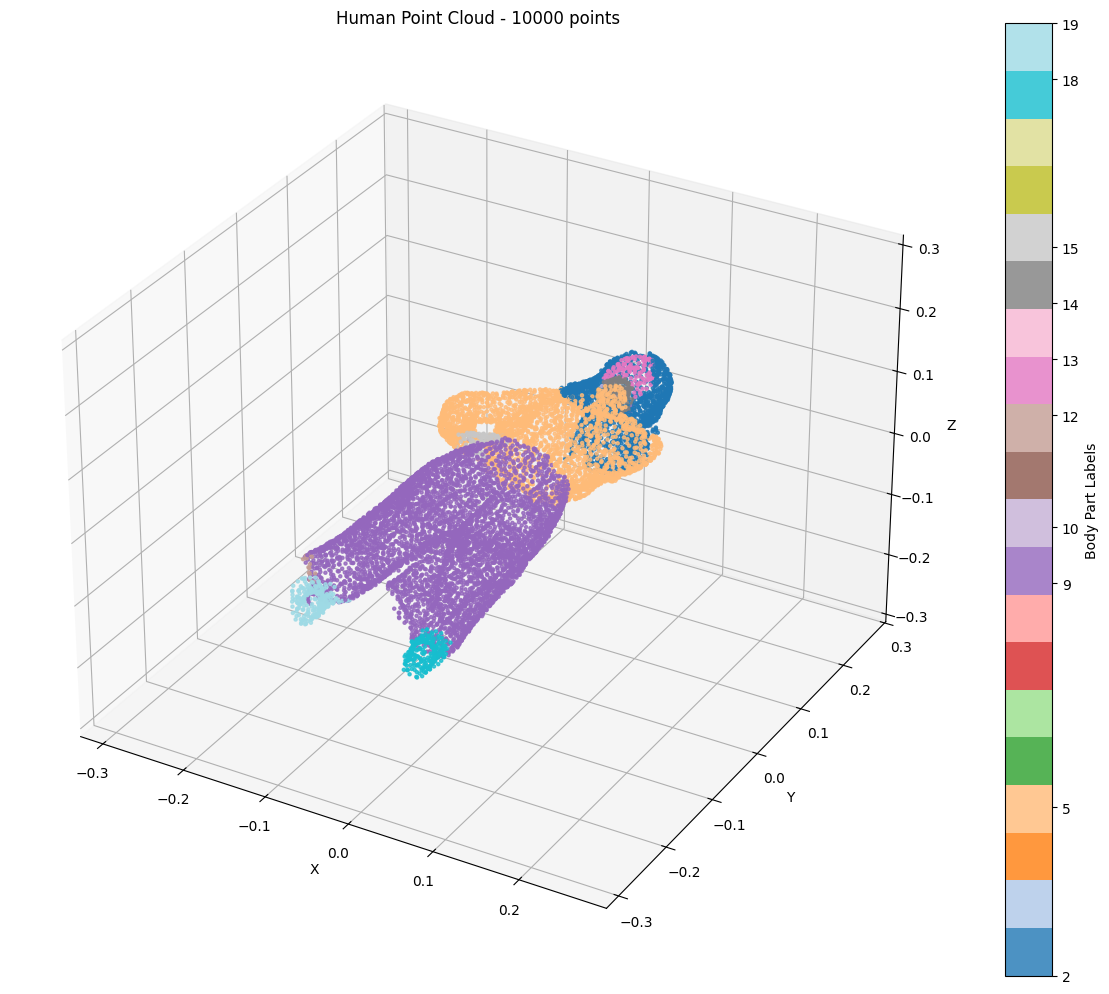

In [11]:
# Let's load and visualize a specific human model
if hdf5_files:
    # Choose the first model in the file
    with h5py.File(first_file, 'r') as f:
        first_model_id = list(f.keys())[22]
    
    print(f"Loading model: {first_model_id}")   
    vertices, labels = explore_human_model(first_file, first_model_id)

Number of points for label 5: 2550


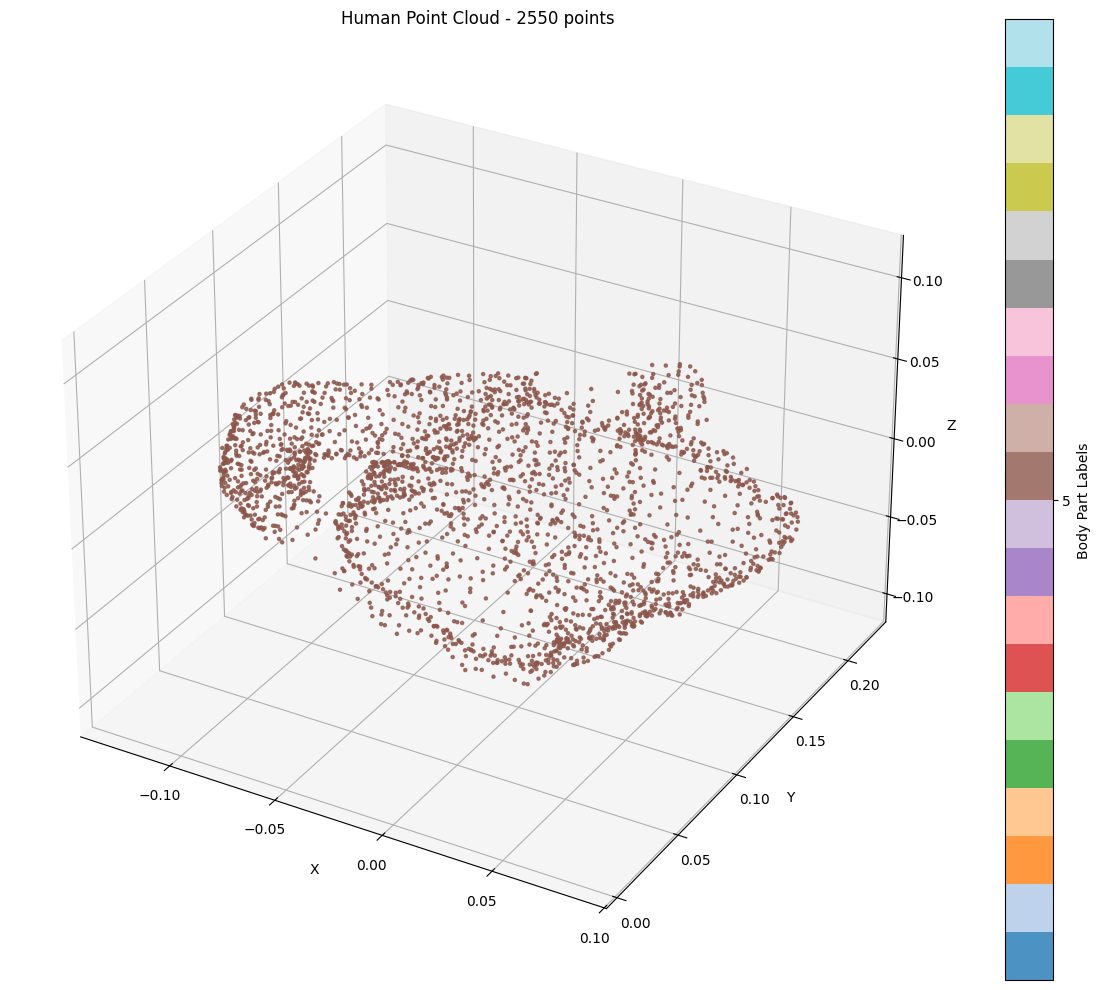

In [12]:
# Specify the label you want to filter
target_label = 5

# Get the mask for the target label
mask = labels == target_label

# Get all points for that label
points_for_label = vertices[mask]

print(f"Number of points for label {target_label}: {points_for_label.shape[0]}")
visualize_point_cloud(points_for_label, np.full(points_for_label.shape[0], target_label))


In [9]:
# Set up ECT parameters
num_thetas = 64  # Number of directions
resolution = 32  # Resolution of ECT grid
radius = 1.0     # Radius for filtration

# Generate uniform directions in 3D
directions = generate_uniform_directions(
    num_thetas=num_thetas,
    d=3,  # 3D space
    seed=42,
    device=device
)

# Create an ECT layer with the specified parameters
ect_layer = ECTLayer(
    ECTConfig(
        ect_type="points",
        resolution=resolution,
        scale=8,
        radius=radius,
        normalized=False,  # Set to False to avoid dimension error in normalize function
        fixed=True  # Use fixed directions for now
    ),
    v=directions
).to(device)

# Compute ECT for a sample point cloud
if hdf5_files and len(dataset) > 0:
    sample_data = dataset[22].to(device)
    
    # Create a batch with just one sample
    batch = Batch.from_data_list([sample_data])
    
    try:
        # Compute ECT
        ect_features = ect_layer(batch)
        
        # Manual normalization if needed (safer than using built-in normalization)
        if ect_features.dim() >= 2:
            # Check if we need to normalize
            if ect_features.max() != 0:
                # Find the maximum value and normalize
                max_val = ect_features.max()
                ect_features = ect_features / max_val
        
        print(f"ECT features shape: {ect_features.shape}")
        print(f"ECT tensor dimensions: {ect_features.dim()}")
        
        # Ensure we have a proper 2D image to visualize
        if ect_features.dim() == 4:
            # If it's a 4D tensor (batch, channels, height, width)
            viz_features = ect_features[0, 0].cpu().numpy()
        elif ect_features.dim() == 3:
            # If it's a 3D tensor (batch, height, width)
            viz_features = ect_features[0].cpu().numpy()
        elif ect_features.dim() == 2:
            # If it's already a 2D tensor (height, width)
            viz_features = ect_features.cpu().numpy()
        else:
            # Handle unexpected dimensions
            viz_features = ect_features.view(resolution, -1).cpu().numpy()
        
        # Visualize the ECT output as an image
        plt.figure(figsize=(10, 8))
        plt.imshow(viz_features, cmap='viridis')
        plt.colorbar(label='ECT Value')
        plt.title('Euler Characteristic Transform (ECT) of Human Point Cloud')
        plt.xlabel('Filtration Step')
        plt.ylabel('Direction')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error computing ECT: {e}")
        print("\nLet's debug the computation:")
        print(f"Sample data shape: {sample_data.x.shape}")
        print(f"Sample batch dimensions: {len(batch)}")
        print(f"Directions tensor shape: {directions.shape}")
        
        # Try simpler ECT computation directly
        print("\nTrying direct ECT computation without the layer:")
        try:
            # Use lower resolution and fewer directions for testing
            test_directions = generate_uniform_directions(
                num_thetas=16,  # Reduced number of directions
                d=3,
                seed=42,
                device=device
            )
            
            ect_direct = compute_ect_points(
                batch.x,
                v=test_directions,
                radius=radius,
                resolution=16,  # Lower resolution
                scale=8,
                index=batch.batch
            )
            
            print(f"Direct ECT computation succeeded with shape: {ect_direct.shape}")
            
            # Visualize the direct computation
            plt.figure(figsize=(10, 8))
            plt.imshow(ect_direct[0].cpu().numpy(), cmap='viridis')
            plt.colorbar(label='ECT Value')
            plt.title('Direct ECT Computation (Simplified)')
            plt.tight_layout()
            plt.show()
            
        except Exception as e2:
            print(f"Direct computation also failed: {e2}")

NameError: name 'dataset' is not defined

In [24]:
# Create a dataset class to handle the human models
class HumanModelDataset(Dataset):
    def __init__(self, h5_file, transform=None):
        """
        Dataset for human models from HDF5 files
        
        Args:
            h5_file: Path to the HDF5 file
            transform: Optional transform to apply to data
        """
        self.h5_file = h5_file
        self.transform = transform
        
        # Get list of models in the file
        with h5py.File(h5_file, 'r') as f:
            self.model_ids = list(f.keys())
        
    def __len__(self):
        return len(self.model_ids)
    
    def __getitem__(self, idx):
        model_id = self.model_ids[idx]
        
        with h5py.File(self.h5_file, 'r') as f:
            group = f[model_id]
            vertices = np.array(group['sampled_vertices'][:])
            labels = np.array(group['sampled_labels'][:])
        
        # Convert to tensor
        vertices_tensor = torch.tensor(vertices, dtype=torch.float)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        
        # Create PyG Data object
        data = Data(x=vertices_tensor, y=labels_tensor)
        
        if self.transform:
            data = self.transform(data)
            
        return data
    
    def get_model_id(self, idx):
        """Return the model ID for a given index"""
        return self.model_ids[idx]

In [25]:
# Load the dataset
if hdf5_files:
    dataset = HumanModelDataset(first_file)
    print(f"Dataset loaded with {len(dataset)} human models")
    
    # Example: access a specific model
    model_idx = 22  # You can change this to access different models
    model_id = dataset.get_model_id(model_idx)
    print(f"Selected model ID: {model_id}")
    
    # Get the model data
    model_data = dataset[model_idx]
    print(f"Model data: {model_data}")
    print(f"Vertices shape: {model_data.x.shape}")
    print(f"Labels shape: {model_data.y.shape}")

Dataset loaded with 2425 human models
Selected model ID: THuman2.1_Release_0-300_0013
Model data: Data(x=[10000, 3], y=[10000])
Vertices shape: torch.Size([10000, 3])
Labels shape: torch.Size([10000])


In [26]:
# Function to extract a specific body part from a model
def extract_body_part(model_data, target_label):
    """
    Extract points for a specific body part from the model
    
    Args:
        model_data: PyG Data object containing the model
        target_label: The label of the body part to extract
        
    Returns:
        PyG Data object containing only points for the target body part
    """
    # Get mask for the target label
    mask = model_data.y == target_label
    
    # Extract vertices for the target label
    part_vertices = model_data.x[mask]
    part_labels = model_data.y[mask]
    
    # Create a new Data object for the body part
    part_data = Data(x=part_vertices, y=part_labels)
    
    return part_data

# Function to compute ECT for a model or body part
def compute_model_ect(data, directions, resolution=32, radius=1.0):
    """
    Compute ECT for a model or body part
    
    Args:
        data: PyG Data object
        directions: Direction vectors for ECT
        resolution: Resolution of ECT grid
        radius: Radius for filtration
        
    Returns:
        ECT features tensor
    """
    # Ensure data is on the correct device
    data = data.to(device)
    
    # Create a batch with just one sample
    batch = Batch.from_data_list([data])
    
    # Compute ECT directly
    ect_features = compute_ect_points(
        batch.x,
        v=directions,
        radius=radius,
        resolution=resolution,
        scale=8,
        index=batch.batch
    )
    
    return ect_features

# Function to visualize ECT
def visualize_ect(ect_features, title="Euler Characteristic Transform (ECT)"):
    """Visualize ECT features as a heatmap"""
    # Ensure we have 2D data to visualize
    if ect_features.dim() == 4:
        viz_features = ect_features[0, 0].cpu().numpy()
    elif ect_features.dim() == 3:
        viz_features = ect_features[0].cpu().numpy()
    elif ect_features.dim() == 2:
        viz_features = ect_features.cpu().numpy()
    else:
        viz_features = ect_features.view(ect_features.shape[0], -1).cpu().numpy()
    
    # Create the visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(viz_features, cmap='viridis')
    plt.colorbar(label='ECT Value')
    plt.title(title)
    plt.xlabel('Filtration Step')
    plt.ylabel('Direction')
    plt.tight_layout()
    plt.show()
    
    return viz_features

Computing ECT for model THuman2.1_Release_0-300_0013...


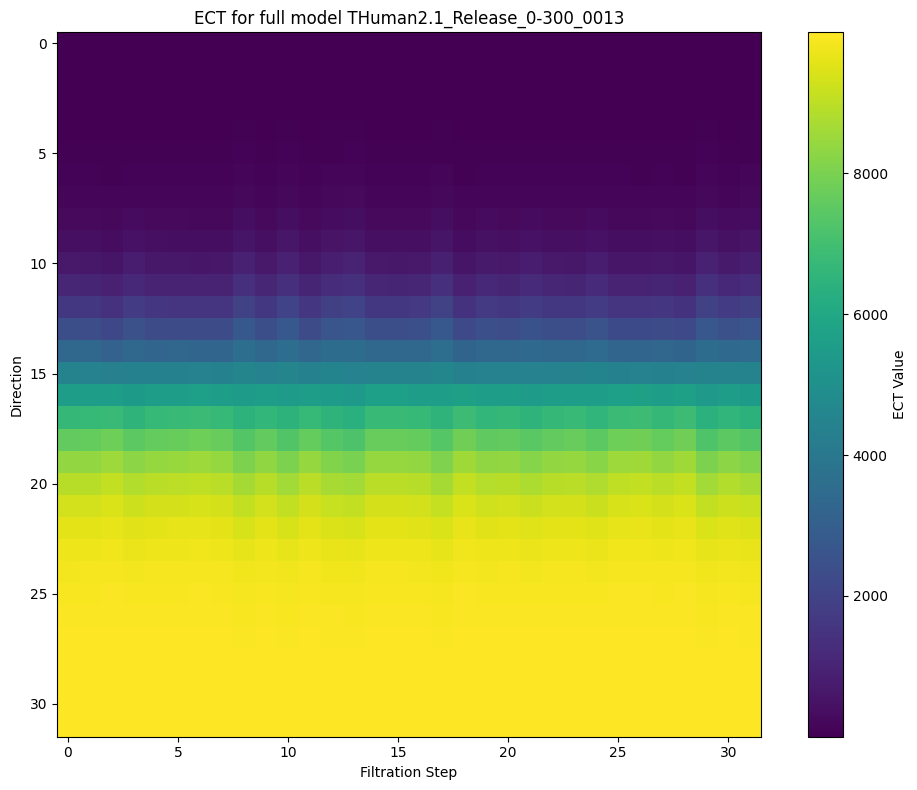

In [27]:
# Example: Compute and visualize ECT for a specific model
if hdf5_files and 'dataset' in locals():
    # Choose a model
    model_idx = 22
    model_data = dataset[model_idx]
    model_id = dataset.get_model_id(model_idx)
    
    # Generate directions
    num_thetas = 32  # Reduced for faster computation
    directions = generate_uniform_directions(
        num_thetas=num_thetas,
        d=3,
        seed=42,
        device=device
    )
    
    # Compute ECT for the entire model
    print(f"Computing ECT for model {model_id}...")
    model_ect = compute_model_ect(model_data, directions, resolution=32)
    
    # Visualize the ECT
    visualize_ect(model_ect, title=f"ECT for full model {model_id}")

Extracting body part with label 5 from model THuman2.1_Release_0-300_0013...
Found 2448 points for body part 5
Found 2448 points for body part 5


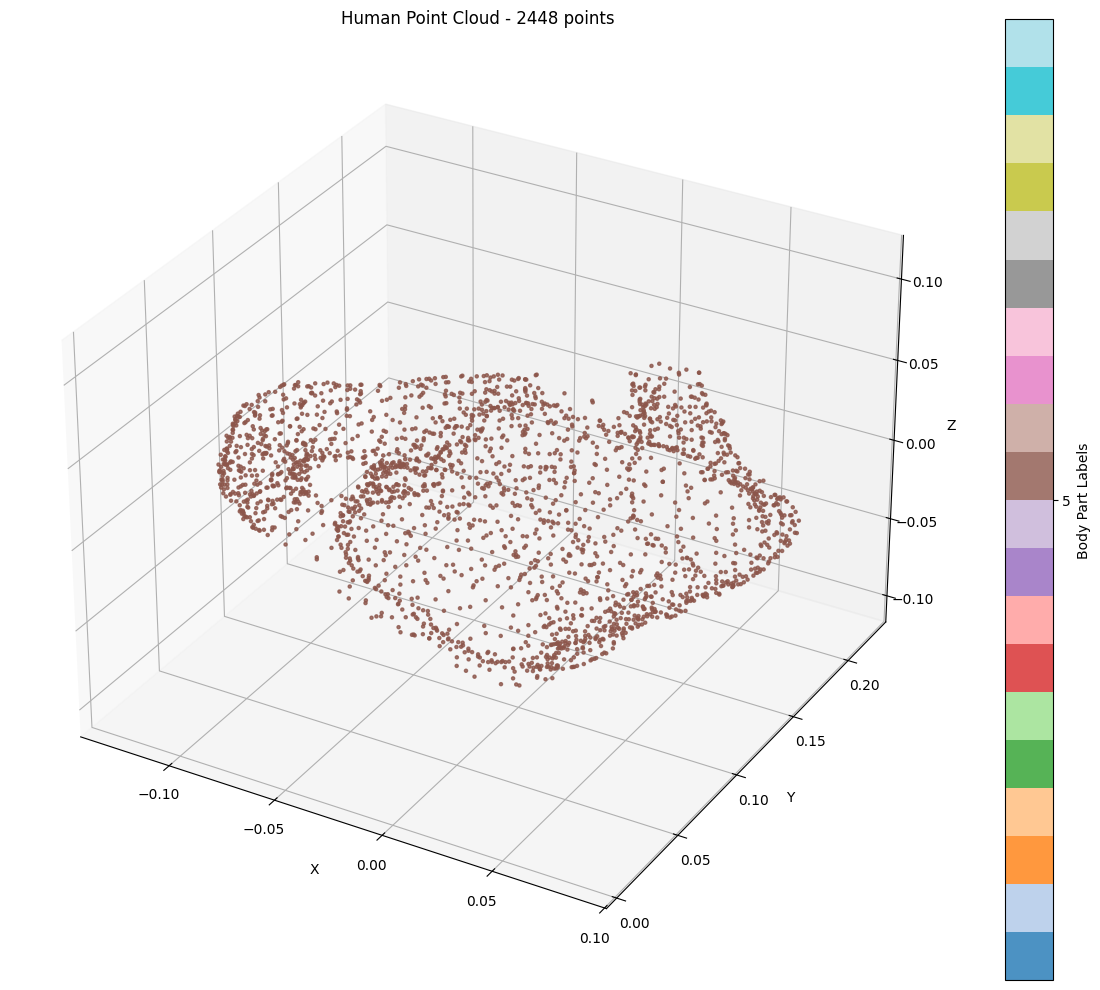

Computing ECT for body part 5...


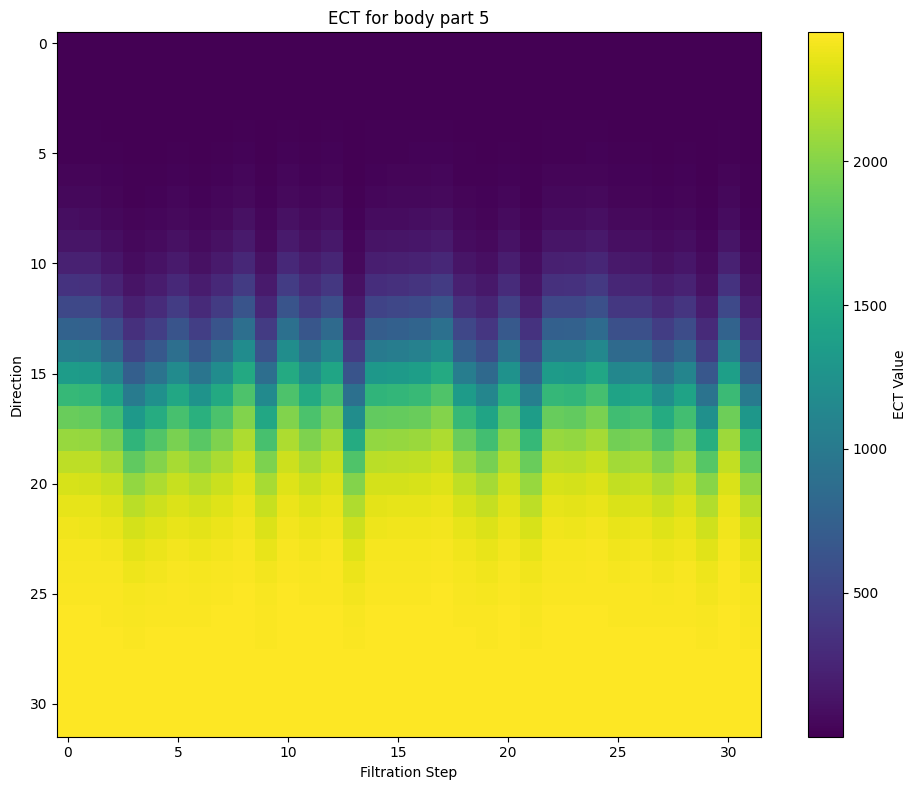

In [28]:
# Example: Compute and visualize ECT for a specific body part
if hdf5_files and 'dataset' in locals():
    # Choose a model and body part
    model_idx = 22
    model_data = dataset[model_idx]
    model_id = dataset.get_model_id(model_idx)
    target_label = 5  # Change this to the body part label you want
    
    # Extract the body part
    print(f"Extracting body part with label {target_label} from model {model_id}...")
    part_data = extract_body_part(model_data, target_label)
    
    # Verify we have points for this body part
    if part_data.x.shape[0] > 0:
        print(f"Found {part_data.x.shape[0]} points for body part {target_label}")
        
        # Visualize the body part
        visualize_point_cloud(
            part_data.x.numpy(), 
            np.full(part_data.x.shape[0], target_label)
        )
        
        # Compute ECT for the body part
        print(f"Computing ECT for body part {target_label}...")
        part_ect = compute_model_ect(part_data, directions, resolution=32)
        
        # Visualize the ECT
        visualize_ect(part_ect, title=f"ECT for body part {target_label}")
    else:
        print(f"No points found for body part label {target_label}")

In [31]:
# Compute and visualize ECT for multiple body parts side by side
def compute_multiple_body_parts_ect(dataset, model_idx, body_part_labels, num_thetas=32, resolution=32):
    """
    Compute and visualize ECT for multiple body parts from the same model
    
    Args:
        dataset: The dataset containing human models
        model_idx: Index of the model to analyze
        body_part_labels: List of body part labels to analyze
        num_thetas: Number of directions for ECT
        resolution: Resolution of ECT grid
    """
    # Get model data
    model_data = dataset[model_idx]
    model_id = dataset.get_model_id(model_idx)
    print(f"Analyzing model: {model_id}")
    
    # Generate directions (shared across all body parts)
    directions = generate_uniform_directions(
        num_thetas=num_thetas,
        d=3,
        seed=42,
        device=device
    )
    
    # Create subplot grid
    n_parts = len(body_part_labels)
    n_cols = min(3, n_parts)  # Maximum 3 columns
    n_rows = (n_parts + n_cols - 1) // n_cols
    
    # Create figure for point clouds
    fig_points = plt.figure(figsize=(n_cols * 6, n_rows * 5))
    
    # Create figure for ECT visualizations
    fig_ect = plt.figure(figsize=(n_cols * 6, n_rows * 5))
    
    # Lists to store results
    part_data_list = []
    ect_features_list = []
    
    # Process each body part
    for i, label in enumerate(body_part_labels):
        print(f"Processing body part {label}...")
        
        # Extract body part
        part_data = extract_body_part(model_data, label)
        part_data_list.append(part_data)
        
        if part_data.x.shape[0] == 0:
            print(f"  - No points found for body part {label}")
            continue
            
        print(f"  - Found {part_data.x.shape[0]} points")
        
        # Compute ECT for the body part
        try:
            part_ect = compute_model_ect(part_data, directions, resolution=resolution)
            ect_features_list.append(part_ect)
            print(f"  - ECT computed successfully with shape {part_ect.shape}")
        except Exception as e:
            print(f"  - Error computing ECT: {e}")
            continue
        
        # Add point cloud subplot
        ax_points = fig_points.add_subplot(n_rows, n_cols, i+1, projection='3d')
        
        # Sample points if too many
        sample_size = min(5000, part_data.x.shape[0])
        if part_data.x.shape[0] > sample_size:
            indices = np.random.choice(part_data.x.shape[0], sample_size, replace=False)
            points = part_data.x[indices].numpy()
        else:
            points = part_data.x.numpy()
        
        # Plot the points
        ax_points.scatter(
            points[:, 0], 
            points[:, 1], 
            points[:, 2], 
            c=np.full(points.shape[0], label), 
            cmap='tab20', 
            s=5, 
            alpha=0.8
        )
        
        ax_points.set_title(f"Body Part {label} ({part_data.x.shape[0]} points)")
        ax_points.set_xlabel('X')
        ax_points.set_ylabel('Y')
        ax_points.set_zlabel('Z')
        
        # Add ECT visualization subplot
        ax_ect = fig_ect.add_subplot(n_rows, n_cols, i+1)
        
        # Get 2D representation of ECT
        if part_ect.dim() == 4:
            viz_features = part_ect[0, 0].cpu().numpy()
        elif part_ect.dim() == 3:
            viz_features = part_ect[0].cpu().numpy()
        elif part_ect.dim() == 2:
            viz_features = part_ect.cpu().numpy()
        else:
            viz_features = part_ect.view(part_ect.shape[0], -1).cpu().numpy()
        
        # Plot ECT heatmap
        im = ax_ect.imshow(viz_features, cmap='viridis')
        ax_ect.set_title(f"ECT for Body Part {label}")
        ax_ect.set_xlabel('Filtration Step')
        ax_ect.set_ylabel('Direction')
        plt.colorbar(im, ax=ax_ect)
    
    # Adjust layout and show figures
    fig_points.tight_layout()
    fig_ect.tight_layout()
    
    plt.figure(fig_points.number)
    plt.show()
    
    plt.figure(fig_ect.number)
    plt.show()
    
    return part_data_list, ect_features_list

Analyzing model: THuman2.1_Release_0-300_0013
Processing body part 0...
  - No points found for body part 0
Processing body part 1...
  - No points found for body part 1
Processing body part 2...
  - Found 1431 points
  - ECT computed successfully with shape torch.Size([1, 32, 32])
Processing body part 3...
  - No points found for body part 3
Processing body part 4...
  - No points found for body part 4
Processing body part 5...
  - Found 2448 points
  - ECT computed successfully with shape torch.Size([1, 32, 32])
Processing body part 3...
  - No points found for body part 3
Processing body part 4...
  - No points found for body part 4
Processing body part 5...
  - Found 2448 points
  - ECT computed successfully with shape torch.Size([1, 32, 32])


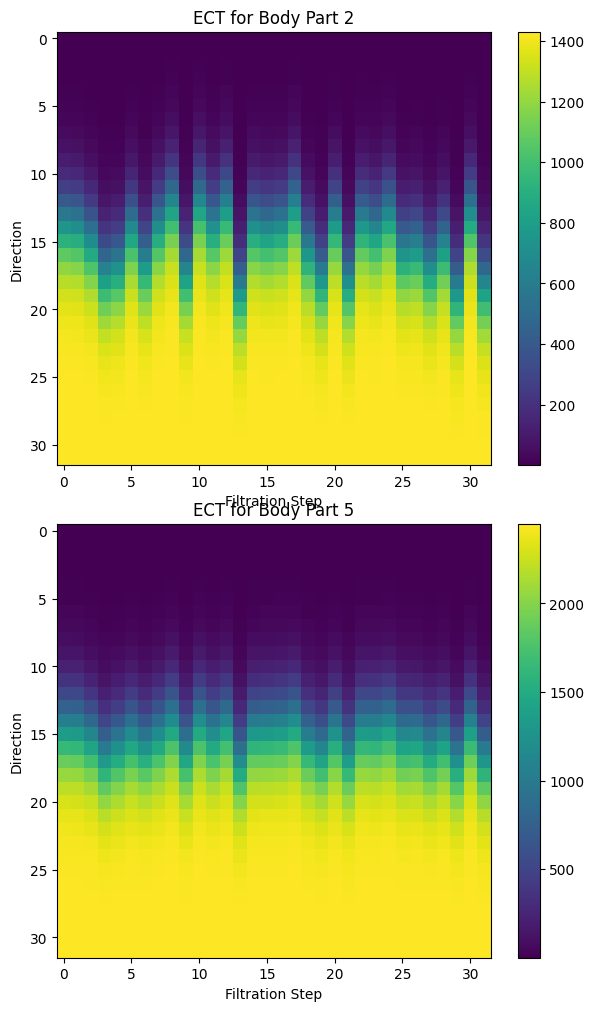

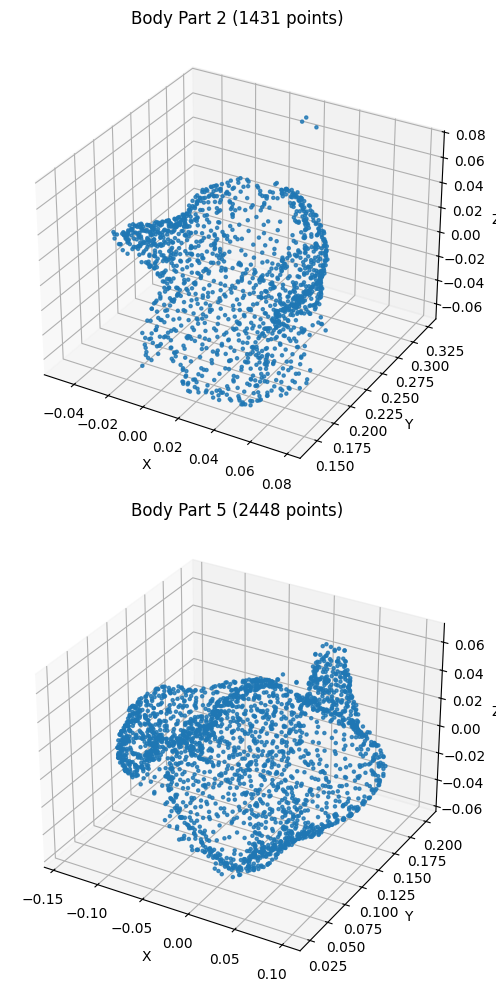

<Figure size 640x480 with 0 Axes>

Processed 2 body parts successfully


In [32]:
# Example usage: Compute and visualize ECT for multiple body parts
if hdf5_files and 'dataset' in locals():
    # Choose a model
    model_idx = 22
    
    # List the body parts you want to analyze
    # You can customize this list based on the labels in your dataset
    body_part_labels = [0, 1, 2, 3, 4, 5]  # Change these to the labels you're interested in
    
    # Compute and visualize ECT for all specified body parts
    parts, ects = compute_multiple_body_parts_ect(dataset, model_idx, body_part_labels)
    
    print(f"Processed {len(ects)} body parts successfully")

In [ ]:
# Function to compute and visualize ECT for all body parts in a compact grid layout
def compute_all_body_parts_ect(dataset, model_idx, num_thetas=32, resolution=32, figsize=(15, 12)):
    """
    Compute and visualize ECT for all body parts in a compact grid layout
    
    Args:
        dataset: The dataset containing human models
        model_idx: Index of the model to analyze
        num_thetas: Number of directions for ECT
        resolution: Resolution of ECT grid
        figsize: Size of the figure for visualization
    """
    # Get model data
    model_data = dataset[model_idx]
    model_id = dataset.get_model_id(model_idx)
    print(f"Analyzing model: {model_id}")
    
    # Find all unique body part labels in this model
    unique_labels = torch.unique(model_data.y).cpu().numpy()
    print(f"Found {len(unique_labels)} unique body parts with labels: {unique_labels}")
    
    # Generate directions (shared across all body parts)
    directions = generate_uniform_directions(
        num_thetas=num_thetas,
        d=3,
        seed=42,
        device=device
    )
    
    # Determine grid layout
    n_parts = len(unique_labels)
    n_cols = min(4, n_parts)  # Up to 4 columns for more compact layout
    n_rows = (n_parts + n_cols - 1) // n_cols
    
    # Create a single figure with subplot grid for ECT visualizations
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = np.array(axes).flatten()
    
    # Store ECT features for each body part
    ect_features_dict = {}
    
    # Process each body part
    for i, label in enumerate(unique_labels):
        print(f"Processing body part {label}...")
        
        # Extract body part
        part_data = extract_body_part(model_data, label)
        
        if part_data.x.shape[0] == 0:
            print(f"  - No points found for body part {label}")
            # Hide this subplot
            axes[i].axis('off')
            axes[i].set_title(f"Body Part {label}: No points")
            continue
            
        print(f"  - Found {part_data.x.shape[0]} points")
        
        try:
            # Compute ECT for the body part
            part_ect = compute_model_ect(part_data, directions, resolution=resolution)
            ect_features_dict[int(label)] = part_ect
            print(f"  - ECT computed successfully")
            
            # Get 2D representation of ECT
            if part_ect.dim() == 4:
                viz_features = part_ect[0, 0].cpu().numpy()
            elif part_ect.dim() == 3:
                viz_features = part_ect[0].cpu().numpy()
            elif part_ect.dim() == 2:
                viz_features = part_ect.cpu().numpy()
            else:
                viz_features = part_ect.view(ect_features.shape[0], -1).cpu().numpy()
            
            # Plot ECT heatmap
            im = axes[i].imshow(viz_features, cmap='viridis')
            axes[i].set_title(f"Part {label} ({part_data.x.shape[0]} pts)")
            
            # Make axes labels smaller for compact layout
            axes[i].tick_params(axis='both', which='major', labelsize=8)
            
            # Add small colorbar
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
        except Exception as e:
            print(f"  - Error computing ECT: {e}")
            axes[i].axis('off')
            axes[i].set_title(f"Body Part {label}: Error")
    
    # Hide any unused subplots
    for j in range(len(unique_labels), len(axes)):
        axes[j].axis('off')
    
    # Add overall title and adjust layout
    plt.suptitle(f"ECT for All Body Parts - Model {model_id}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    plt.show()
    
    # Now create a compact point cloud visualization for reference
    fig2 = plt.figure(figsize=(10, 8))
    ax = fig2.add_subplot(111, projection='3d')
    
    # Sample points from the full model for visualization
    sample_size = min(10000, model_data.x.shape[0])
    if model_data.x.shape[0] > sample_size:
        indices = np.random.choice(model_data.x.shape[0], sample_size, replace=False)
        points = model_data.x[indices].numpy()
        point_labels = model_data.y[indices].numpy()
    else:
        points = model_data.x.numpy()
        point_labels = model_data.y.numpy()
    
    # Plot the full model with color-coded body parts
    scatter = ax.scatter(
        points[:, 0], 
        points[:, 1], 
        points[:, 2], 
        c=point_labels, 
        cmap='tab20', 
        s=3, 
        alpha=0.7
    )
    
    # Add colorbar with label ticks
    unique_labels_list = unique_labels.tolist()
    cbar = plt.colorbar(scatter, ax=ax, ticks=unique_labels_list)
    cbar.set_label('Body Part Labels')
    
    ax.set_title(f"Model {model_id} - All Body Parts")
    plt.tight_layout()
    plt.show()
    
    return ect_features_dict

In [ ]:
# Make sure we have the necessary imports for the divider
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Example usage: Compute and visualize ECT for all body parts in a model
if hdf5_files and 'dataset' in locals():
    # Choose a model to analyze
    model_idx = 22  # You can change this to analyze a different model
    
    # Compute ECT for all body parts in the model with a compact visualization
    ect_features = compute_all_body_parts_ect(dataset, model_idx, num_thetas=32, resolution=32)
    
    print(f"Successfully computed ECT for {len(ect_features)} body parts")

## Comparing ECT Features Between Body Parts

You can use the following cell to compare specific ECT features between different body parts or to perform further analysis on the computed ECT features.

In [ ]:
# Function to visualize multiple ECT features side by side for comparison
def compare_body_part_ects(ect_features_dict, part_labels_to_compare, figsize=(15, 5)):
    """
    Compare ECT features between specific body parts
    
    Args:
        ect_features_dict: Dictionary of ECT features keyed by body part label
        part_labels_to_compare: List of body part labels to compare
        figsize: Size of the figure
    """
    # Filter to only the requested parts that exist in our dictionary
    existing_parts = [label for label in part_labels_to_compare if label in ect_features_dict]
    
    if not existing_parts:
        print("None of the requested body parts have computed ECT features.")
        return
    
    # Create figure
    fig, axes = plt.subplots(1, len(existing_parts), figsize=figsize)
    
    # Handle case with only one subplot
    if len(existing_parts) == 1:
        axes = [axes]
    
    # Plot ECT for each selected body part
    for i, label in enumerate(existing_parts):
        ect = ect_features_dict[label]
        
        # Get 2D visualization
        if ect.dim() == 4:
            viz_features = ect[0, 0].cpu().numpy()
        elif ect.dim() == 3:
            viz_features = ect[0].cpu().numpy()
        elif ect.dim() == 2:
            viz_features = ect.cpu().numpy()
        else:
            viz_features = ect.view(ect.shape[0], -1).cpu().numpy()
        
        # Plot the heatmap
        im = axes[i].imshow(viz_features, cmap='viridis')
        axes[i].set_title(f"Body Part {label}")
        axes[i].set_xlabel('Filtration Step')
        axes[i].set_ylabel('Direction')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    
    return

# Example of how to compare specific body parts (run after computing all ECTs)
if 'ect_features' in locals() and len(ect_features) > 0:
    # Select specific body parts to compare (replace with your desired labels)
    parts_to_compare = [0, 1, 5]  
    compare_body_part_ects(ect_features, parts_to_compare)